In [1]:
# library
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal as signal

In [2]:
def load_semg_data(data_folder):
    """
    Load sEMG data from subject folders (names starting with 'HS') in data_folder.
    Returns a nested dict: {subject: {gesture: semg_array}}.
    """
    semg_data = {}
    for subject in os.listdir(data_folder):
        subject_path = os.path.join(data_folder, subject)
        if os.path.isdir(subject_path) and subject.startswith('HS'):
            semg_data[subject] = {}
            for filename in os.listdir(subject_path):
                if filename.endswith('.mat'):
                    gesture_name = os.path.splitext(filename)[0]
                    file_path = os.path.join(subject_path, filename)
                    mat_contents = scipy.io.loadmat(file_path)
                    for key in mat_contents:
                        if not key.startswith('__'):
                            semg_array = mat_contents[key]
                            break
                    semg_data[subject][gesture_name] = semg_array
    return semg_data

# Example usage:
data_folder_path = 'Data'
structured_data = load_semg_data(data_folder_path)
print(structured_data.keys())


dict_keys(['HS1', 'HS2', 'HS3', 'HS4', 'HS5', 'HS6', 'HS7', 'HS8'])


In [3]:
# ==========================
# Hyperparameter Definitions
# ==========================
fs = 2048              # Sampling frequency (Hz)
bp_low = 20.0          # Bandpass low cutoff (Hz)
bp_high = 450.0        # Bandpass high cutoff (Hz)
order_bp = 4           # Filter order

nyq = 0.5 * fs
b_bp, a_bp = signal.butter(order_bp, [bp_low/nyq, bp_high/nyq], btype='bandpass')

notch_freq = 50.0      # Notch filter center frequency (Hz)
Q = 50.0               # Quality factor
w0 = notch_freq / nyq
b_notch, a_notch = signal.iirnotch(w0, Q)

window_size = int(fs * 0.2)
window = np.ones(window_size) / window_size

# ==========================
# Preprocessing Helper Functions
# ==========================
def preprocess_signal(sig):
    """Apply bandpass, notch filtering, then full-wave rectification."""
    filtered = signal.filtfilt(b_bp, a_bp, sig)
    filtered = signal.filtfilt(b_notch, a_notch, filtered)
    return np.abs(filtered)

def moving_average(sig):
    """Apply moving average with a 200 ms window."""
    return np.convolve(sig, window, mode='same')

# ==========================
# Create Processed Data (without modifying structured_data)
# ==========================
processed_data = {}

for subject, gestures in structured_data.items():
    print(f"Processing subject: {subject} ...")
    processed_data[subject] = {}
    for gesture, data in gestures.items():
        if isinstance(data, np.ndarray) and data.ndim == 2 and data.shape[0] == 64:
            processed = np.zeros_like(data)
            for ch in range(data.shape[0]):
                processed[ch, :] = preprocess_signal(data[ch, :])
            processed_data[subject][gesture] = processed
        else:
            print(f"Skipping {subject} - {gesture}: Data format unexpected.")
    
    if "MVC" in processed_data[subject]:
        mvc_data = processed_data[subject]["MVC"]
        mvc_smoothed = np.zeros_like(mvc_data)
        mvc_max = np.zeros(mvc_data.shape[0])
        for ch in range(mvc_data.shape[0]):
            mvc_smoothed[ch, :] = moving_average(mvc_data[ch, :])
            mvc_max[ch] = np.max(mvc_smoothed[ch, :])
        processed_data[subject]["MVC_max"] = mvc_max
        for gesture, data in processed_data[subject].items():
            if gesture in ["MVC", "MVC_max"]:
                continue
            for ch in range(data.shape[0]):
                processed_data[subject][gesture][ch, :] = data[ch, :] / mvc_max[ch] if mvc_max[ch] != 0 else 0
    else:
        print(f"Subject {subject} does not have an 'MVC' gesture. Skipping normalization.")

print("Preprocessing complete.")


Processing subject: HS1 ...
Processing subject: HS2 ...
Processing subject: HS3 ...
Processing subject: HS4 ...
Processing subject: HS5 ...
Processing subject: HS6 ...
Processing subject: HS7 ...
Processing subject: HS8 ...
Preprocessing complete.


Selected Subject: HS1
Available Gestures: ['closehand', 'MVC', 'openhand', 'pointer', 'thumb_ext', 'thumb_flex', 'wrist_ext', 'wrist_flex', 'MVC_max']
Selected Gesture: closehand
Shape of sEMG Data (Channels x Time Steps): (64, 135633)
(64,) (64,) (64,)
[8.09396211e-02 1.10180067e-01 1.00928573e-01 4.01665861e-02
 5.58873455e-02 7.27832316e-02 6.65124167e-02 2.28225896e-08
 2.99051794e-02 3.15222744e-02 3.18426751e-02 4.36749259e-02
 1.30860778e-02 7.82397789e-02 5.24031536e-02 1.03732285e-02
 1.45556273e-02 1.05933169e-02 9.28830441e-03 1.56812623e-03
 1.77542036e-02 4.36132613e-03 1.06663533e-02 5.47944876e-02
 1.44283213e-01 6.01127184e-02 6.91115259e-02 2.14056040e-02
 9.47635053e-03 3.33643125e-02 5.16481003e-02 5.05913284e-02
 7.14944647e-02 3.08527703e-02 1.78352808e-03 6.63422790e-03
 1.10538207e-03 1.68785431e-02 5.04836951e-03 1.29384973e-02
 1.12470918e-02 3.91050335e-02 1.90447641e-01 2.08711698e-02
 2.41466012e-02 1.72064072e-02 1.41111260e-02 6.15981253e-02
 5.16021581e-0

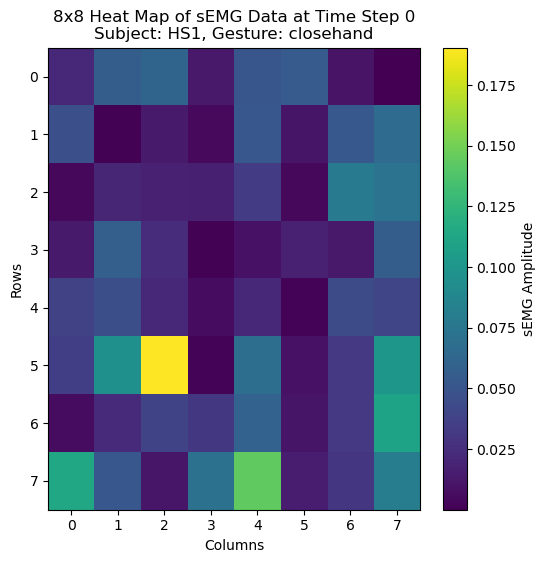

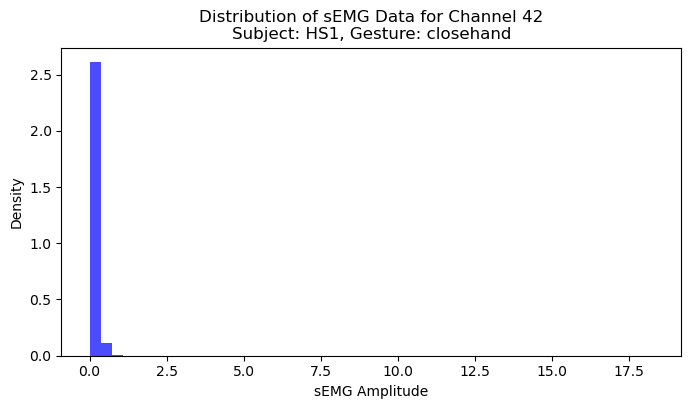

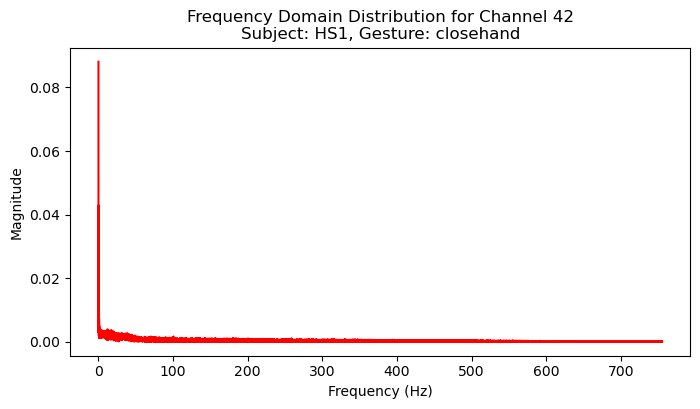

In [4]:
#### check if data are retrieved correctly
# Select a subject and gesture for demonstration
subject_names = list(processed_data.keys())
selected_subject = subject_names[0]

# Get the list of gesture names for the selected subject
gesture_names = list(processed_data[selected_subject].keys())
selected_gesture = gesture_names[0]

# Retrieve the sEMG data for the selected subject and gesture
semg_data = processed_data[selected_subject][selected_gesture]

# Print details about the subject and its sEMG data
print("Selected Subject:", selected_subject)
print("Available Gestures:", gesture_names)
print("Selected Gesture:", selected_gesture)
print("Shape of sEMG Data (Channels x Time Steps):", semg_data.shape)

# Select a specific time step
time_step = 0
# Extract the 1D array (64,) for the selected time step
selected_time_data = semg_data[:, time_step]

# Create an index array for sensors 0 to 63
indices = np.arange(64)
# map the index order to actual 8x8 matrix
rows = 7 - (indices % 8)
cols = 7 - (indices // 8)
print(selected_time_data.shape, rows.shape, cols.shape)

# Create an empty 8x8 matrix and assign sensor values using vectorized indexing
heatmap_matrix = np.zeros((8, 8))
heatmap_matrix[rows, cols] = selected_time_data
print(selected_time_data)
print(heatmap_matrix)
# Compute robust color scaling limits using the 5th and 95th percentiles
# vmin = np.percentile(heatmap_matrix, 5)
# vmax = np.percentile(heatmap_matrix, 95)

plt.figure(figsize=(6, 6))
plt.imshow(heatmap_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='sEMG Amplitude')
plt.title(f"8x8 Heat Map of sEMG Data at Time Step {time_step}\nSubject: {selected_subject}, Gesture: {selected_gesture}")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


# -------------------------
# 3. Plot Distribution for a Selected Channel
# -------------------------
# the current selected channel is 0, but this channel does not show significant change during the gesture of "close hand"
# Select one channel for distribution analysis (e.g., channel 0)
selected_channel = 42
channel_data = semg_data[selected_channel, :]

plt.figure(figsize=(8, 4))
plt.hist(channel_data, bins=50, density=True, alpha=0.7, color='blue')
plt.xlabel("sEMG Amplitude")
plt.ylabel("Density")
plt.title(f"Distribution of sEMG Data for Channel {selected_channel}\nSubject: {selected_subject}, Gesture: {selected_gesture}")
plt.show()

# -------------------------
# 4. Plot Frequency Domain Distribution for the Selected Channel
# -------------------------

fs = 2048  # Sampling frequency in Hz  
N = len(channel_data)

# Compute FFT and corresponding frequency bins
fft_vals = np.fft.fft(channel_data)
fft_freq = np.fft.fftfreq(N, d=1/fs)

# Use only the positive frequencies
mask = fft_freq >= 0
fft_freq = fft_freq[mask]
fft_magnitude = np.abs(fft_vals[mask]) / N  # normalize by the number of samples

plt.figure(figsize=(8, 4))
plt.plot(fft_freq[:50000], fft_magnitude[0:50000], color='red')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title(f"Frequency Domain Distribution for Channel {selected_channel}\nSubject: {selected_subject}, Gesture: {selected_gesture}")
plt.show()

In [5]:
# ==========================
# Segmentation Parameters
# ==========================
active_start_offset = 4    # Active segment start time (s)
active_end_offset   = 5    # Active segment end time (s)
rest_start_offset   = 1    # Rest segment start time (s)
rest_end_offset     = 2    # Rest segment end time (s)
cycle_duration      = 6    # Cycle duration (s)

window_duration = 0.2      # Window duration (s)
step_duration   = 0.05     # Step duration (s)
window_samples  = int(window_duration * fs)
step_size       = int(step_duration * fs)

def segment_window(segment, window_samples, step):
    """Segment a 2D array (channels x L) into overlapping windows."""
    windows = []
    L = segment.shape[1]
    for start in range(0, L - window_samples + 1, step):
        windows.append(segment[:, start:start + window_samples])
    return windows

# ==========================
# Main Segmentation Loop
# ==========================
segmented_data = {}

for subject, gestures in processed_data.items():
    print(f"Segmenting subject: {subject} ...")
    segmented_data[subject] = {}
    segmented_data[subject]["rest"] = []
    
    for gesture, data in gestures.items():
        if gesture in ["MVC", "MVC_max"]:
            continue
        segmented_data[subject].setdefault(gesture, [])
        num_channels, N_samples = data.shape
        n = 0
        while True:
            active_start = int((active_start_offset + cycle_duration * n) * fs)
            active_end   = int((active_end_offset   + cycle_duration * n) * fs)
            rest_start   = int((rest_start_offset   + cycle_duration * n) * fs)
            rest_end     = int((rest_end_offset     + cycle_duration * n) * fs)
            if active_end > N_samples or rest_end > N_samples:
                break
            active_segment = data[:, active_start:active_end]
            rest_segment   = data[:, rest_start:rest_end]
            active_windows = segment_window(active_segment, window_samples, step_size)
            rest_windows   = segment_window(rest_segment, window_samples, step_size)
            segmented_data[subject][gesture].extend(active_windows)
            segmented_data[subject]["rest"].extend(rest_windows)
            n += 1

print("Segmentation complete.")


Segmenting subject: HS1 ...
Segmenting subject: HS2 ...
Segmenting subject: HS3 ...
Segmenting subject: HS4 ...
Segmenting subject: HS5 ...
Segmenting subject: HS6 ...
Segmenting subject: HS7 ...
Segmenting subject: HS8 ...
Segmentation complete.


In [6]:

import pickle

with open("segmented_data.pkl", "wb") as f:
    pickle.dump(segmented_data, f)

print("segmented_data has been saved to 'segmented_data.pkl'.")
for subject, gestures in segmented_data.items():
    print(f"Subject: {subject}")
    for gesture, windows in gestures.items():
        num_windows = len(windows)
        print(f"  Gesture: {gesture} - Number of windows: {num_windows}")
        if num_windows > 0:
            print(f"    Example window shape: {windows[0].shape}")

segmented_data has been saved to 'segmented_data.pkl'.
Subject: HS1
  Gesture: rest - Number of windows: 1309
    Example window shape: (64, 409)
  Gesture: closehand - Number of windows: 187
    Example window shape: (64, 409)
  Gesture: openhand - Number of windows: 187
    Example window shape: (64, 409)
  Gesture: pointer - Number of windows: 187
    Example window shape: (64, 409)
  Gesture: thumb_ext - Number of windows: 187
    Example window shape: (64, 409)
  Gesture: thumb_flex - Number of windows: 187
    Example window shape: (64, 409)
  Gesture: wrist_ext - Number of windows: 187
    Example window shape: (64, 409)
  Gesture: wrist_flex - Number of windows: 187
    Example window shape: (64, 409)
Subject: HS2
  Gesture: rest - Number of windows: 1309
    Example window shape: (64, 409)
  Gesture: closehand - Number of windows: 187
    Example window shape: (64, 409)
  Gesture: openhand - Number of windows: 187
    Example window shape: (64, 409)
  Gesture: pointer - Number